In [1]:
from dotenv import load_dotenv
from google.cloud import bigquery
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import plotly.express as px
from pyoso import Client
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

import matplotlib.ticker as mticker
from matplotlib.colors import LogNorm
import matplotlib.dates as mdates

load_dotenv()
OSO_API_KEY = os.environ['OSO_API_KEY']
client = Client(api_key=OSO_API_KEY)

os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = '../../../oso_gcp_credentials.json'
GCP_PROJECT = 'opensource-observer'
gcp_client = bigquery.Client(project=GCP_PROJECT)

stringify = lambda arr: "'" + "','".join(arr) + "'"

In [2]:
# Analysis parameters
MOST_RECENT_MEASUREMENT_PERIOD = 5

HISTORIC_START_DATE = "2023-01-01"
HISTORIC_END_DATE   = "2025-06-30"

DAILY_START_DATE = "2025-01-01"
DAILY_END_DATE   = "2025-06-30"

MONTHLY_START_DATE = "2025-01-01"
MONTHLY_END_DATE   = "2025-06-01"

RETROFUNDING_REPO_URL = "https://raw.githubusercontent.com/ethereum-optimism/Retro-Funding/refs/heads/main/results/S7"

OP_RED = "#FF0420"

# Queries

## Projects & Rewards

In [3]:
df_onchain_projects = client.to_pandas("""
   SELECT DISTINCT
     p.project_id AS oso_id,
     p.project_name AS atlas_id,
     p.display_name AS project_name
   FROM projects_v1 AS p
   JOIN projects_by_collection_v1 AS pbc ON p.project_id = pbc.project_id
   JOIN collections_v1 AS c ON pbc.collection_id = c.collection_id
   WHERE c.display_name = 'Retro Funding S7: Onchain Builders'
""")

df_onchain_projects

,oso_id,atlas_id,project_name
0,mdb4FjuCCmOI5Tc+xwDeXfQd/1Nm2o7JZy8ZHzlxC9o=,0x259b729af86ba38c0c84be9b739dfbca109a6df98537...,Flaunch
1,GUim2XveZhjh9BqT8XLOSXQhnOsdjQ4dzzBhJ8jMBS8=,0x019ccd1a7cafff57a05d1dc463ad4acd4d138ad4f7c7...,Flight to Zora Planet
2,AWt4h9zeTVKtlCCptcCdxAqt1P8tHvgZLjpDLlttfmc=,0x740297a85de756f69945e2cfd9d439598cdb06a70e40...,TOCD Studio
3,qpgChJsGqtFnDQQU8CdZ8Ab5N/OjV4xdwEw5irdZl4A=,0xdba6f6be6f7cddd6b7f291292ab4179ad4dbe92fc8a8...,LasMeta
4,93BBdChzOJAS6sfGob9PLuLiC+NwuB5EJVVW/DHQ2vM=,0x5b054742b09f8ce4092a15700ef9781520a6ff2928ba...,Kiwi News
...,...,...,...
320,PGjtfbpmLLToc8ZGaQ4geVocppIklmpcQsfzGFzUo/M=,0xb0eeb25c9bc02dbc42c73840a84e65890f7a37332593...,Token Machine gun
321,u4P3wjawfNUxPEqdDc6q9H/PutT20/+kNiMDjfl0grw=,0x76596da0afbf2980ce80e6238c974495fbe52f5c29ec...,DAOBase
322,hBbXQVnA9/wU80tI+49GgAxxFtLFCXAhUPIS+1U0Gks=,0xf2780313b6d15a9be15973bac05fcb0d849d656f63ac...,LogX
323,RxXGYOjkq3yGRUj1eBJ+pZhWpYLbIUaseRbZ/24DJuI=,0xe3d0892ac820afd317c8073e3fc8e599f1801019e86b...,Optimistic Builder Dollar


In [4]:
def get_round_results(m_id, category):
    url = f"{RETROFUNDING_REPO_URL}/M{m_id}/outputs/{category}__results.json"
    result = pd.read_json(url)
    result = result[['op_atlas_id', 'op_reward']]
    result.columns = ['atlas_id', 'op_reward']
    result['category'] = category
    result['measurement_period'] = m_id
    return result

def get_all_round_results(category):
    dfs = []
    for m_id in range(1, MOST_RECENT_MEASUREMENT_PERIOD + 1):
        dfs.append(get_round_results(m_id, category))
    return pd.concat(dfs, axis=0, ignore_index=True)

df_onchain_rewards = get_all_round_results("onchain").groupby('atlas_id', as_index=False)['op_reward'].sum()
df_onchain_rewards['is_funded'] = df_onchain_rewards['op_reward'] > 0
df_onchain_rewards

,atlas_id,op_reward,is_funded
0,0x0008577196fa6ec286440b418e2f6305fc10e62ce759...,25173.17,True
1,0x000c2ce4773defb3010a58d3800d0ec9d432189c574b...,30777.19,True
2,0x00d5eaebec0fa6a41bbf5e29d347162dabc04dfffcd1...,56873.92,True
3,0x019ccd1a7cafff57a05d1dc463ad4acd4d138ad4f7c7...,265.25,True
4,0x02065e72fe4eebfa1ebca19238e6147c8571c2b7fefa...,1218.77,True
...,...,...,...
313,0xfd9f98de666c5b0a5ce96d4a4b8d4ceee9f8c2156734...,6286.71,True
314,0xfe8e35b3487bd0e0457b9431b12b73403ca1f5c9c19d...,39491.30,True
315,0xff1edf67227651293a9cff4dce3577c6ca52bf8c7c6f...,24478.28,True
316,0xff350d81524a79a1062f5f4977b45406b822fb4f150b...,0.00,False


## Onchain Metrics

In [5]:
df_daily_metrics_by_chain_and_project = client.to_pandas(f"""
WITH metrics AS (
  SELECT
    metric_id,
    chain, 
    display_name AS metric
  FROM metrics_v0
  CROSS JOIN int_superchain_chain_names AS chains
  WHERE (
    metric_name LIKE '%_transactions_daily'
    OR metric_name LIKE '%_defillama_tvl_daily'
  )
  AND metric_name LIKE CONCAT(chain, '%')
)

SELECT
  tm.sample_date,
  tm.project_id,
  m.chain,
  m.metric,
  SUM(tm.amount) AS amount
FROM timeseries_metrics_by_project_v0 AS tm
JOIN metrics AS m ON tm.metric_id = m.metric_id
WHERE 
  tm.sample_date BETWEEN DATE('{HISTORIC_START_DATE}') AND DATE('{HISTORIC_END_DATE}')
  AND tm.project_id IN ({stringify(df_onchain_projects['oso_id'])})
GROUP BY 1,2,3,4
ORDER BY 1,2,3,4
""")

df_daily_metrics_by_chain_and_project['sample_date'] = pd.to_datetime(df_daily_metrics_by_chain_and_project['sample_date'])
df_daily_metrics_by_chain_and_project

,sample_date,project_id,chain,metric,amount
0,2023-01-01,0eM1b8HKnTMw5hgzgPw3l3m4A4wwTQd/0e1rFWNPz8o=,OPTIMISM,Transactions,4.0
1,2023-01-01,23XIt7EgzQNc2AdcEzTg7GbjT5kKY1lNFfmcGQvrkWA=,BOB,Defillama TVL,44685.79665
2,2023-01-01,23XIt7EgzQNc2AdcEzTg7GbjT5kKY1lNFfmcGQvrkWA=,OPTIMISM,Defillama TVL,3444184.85784
3,2023-01-01,23XIt7EgzQNc2AdcEzTg7GbjT5kKY1lNFfmcGQvrkWA=,OPTIMISM,Transactions,14502.0
4,2023-01-01,5/9fRbVoDF7pHwBdiMbNUbKhidEt/12Ojt9f8cWoZnQ=,OPTIMISM,Defillama TVL,75048565.4008
...,...,...,...,...,...
234209,2025-06-30,yHC4i4mkg5sXaXOF4Mih0UyHDYVS7+0+9zuqnDFvClY=,INK,Transactions,1930.0
234210,2025-06-30,zVWBMiOJHTeEPXEgWSl1B+tsS8W9vwfv2QU32ANB8yY=,BASE,Transactions,1.0
234211,2025-06-30,zdNq7Cvjqx03oRiL22rCANVA7/8MBGaoc3InNwm3LCA=,WORLDCHAIN,Transactions,1.0
234212,2025-06-30,zpXh+xI4A77C9Y/ortXA0jU/33Zj+QztUOpW3hJ+w8A=,BASE,Transactions,13.0


In [6]:
df_monthly_metrics_by_chain_and_project = client.to_pandas(f"""
SELECT
  DATE_FORMAT(sample_date, '%Y-%m-%d') AS sample_date,
  project_id,
  chain,
  metric_name AS metric,
  amount
FROM int_superchain_s7_onchain_metrics_by_project
WHERE
  project_id IN ({stringify(df_onchain_projects['oso_id'])})
  AND sample_date BETWEEN DATE('{MONTHLY_START_DATE}') AND DATE('{MONTHLY_END_DATE}')
ORDER BY 1,2,3,4  
""")
df_monthly_metrics_by_chain_and_project

,sample_date,project_id,chain,metric,amount
0,2025-01-01,+Xyt1tUxrXrbR9UH3h/0BmCBJJpBDBuFyJFBdmt/U44=,BASE,active_addresses_monthly,953.0
1,2025-01-01,+Xyt1tUxrXrbR9UH3h/0BmCBJJpBDBuFyJFBdmt/U44=,BASE,active_farcaster_users_monthly,60.0
2,2025-01-01,+Xyt1tUxrXrbR9UH3h/0BmCBJJpBDBuFyJFBdmt/U44=,BASE,amortized_contract_invocations_monthly,1373.0
3,2025-01-01,+Xyt1tUxrXrbR9UH3h/0BmCBJJpBDBuFyJFBdmt/U44=,BASE,average_tvl_monthly,14022271.524434
4,2025-01-01,+Xyt1tUxrXrbR9UH3h/0BmCBJJpBDBuFyJFBdmt/U44=,BASE,contract_invocations_monthly,2029.0
...,...,...,...,...,...
37914,2025-06-01,zpXh+xI4A77C9Y/ortXA0jU/33Zj+QztUOpW3hJ+w8A=,ZORA,gas_fees_monthly,0.000006
37915,2025-06-01,zpXh+xI4A77C9Y/ortXA0jU/33Zj+QztUOpW3hJ+w8A=,ZORA,gas_fees_transaction_level_only_monthly,0.000005
37916,2025-06-01,zpXh+xI4A77C9Y/ortXA0jU/33Zj+QztUOpW3hJ+w8A=,ZORA,internal_transactions_monthly,1084.0
37917,2025-06-01,zpXh+xI4A77C9Y/ortXA0jU/33Zj+QztUOpW3hJ+w8A=,ZORA,qualified_addresses_monthly,0.0


In [7]:
df_daily_metrics_by_project = (
    df_daily_metrics_by_chain_and_project
    .groupby(['sample_date', 'project_id', 'metric'], as_index=False)['amount']
    .sum()
)
df_monthly_metrics_by_project = (
    df_monthly_metrics_by_chain_and_project
    .groupby(['sample_date', 'project_id', 'metric'], as_index=False)['amount']
    .sum()
)

## Gas Fees & Deployments

In [8]:
REFRESH = False
if REFRESH:
    df_gas_fees = gcp_client.query(f"""
    WITH projects AS (
      SELECT
        project_id,
        artifact_name AS address,
        artifact_source AS chain
      FROM `oso_production.artifacts_by_project_v1`
      WHERE project_id IN ({stringify(df_onchain_projects['oso_id'])})
    ),
    txns AS (
      SELECT
        dt,
        to_address,
        CASE
          WHEN chain = 'op' THEN 'OPTIMISM'
          WHEN chain = 'fraxtal' THEN 'FRAX'
          ELSE UPPER(chain)
        END AS chain,
        (receipt_gas_used / 1e18 * receipt_effective_gas_price) AS gas_fee
      FROM `optimism_superchain_raw_onchain_data.transactions`
      WHERE dt >= '{HISTORIC_START_DATE}'
    )    
    SELECT
      txns.dt,
      projects.project_id,
      txns.chain,
      SUM(gas_fee) AS gas_fees
    FROM txns
    JOIN projects
      ON
        txns.to_address = projects.address
        AND txns.chain = projects.chain
    GROUP BY 1,2,3
    """).to_dataframe()
    df_gas_fees.to_parquet('data/20250714_s7_onchain_builder_gasfees.parquet')
else:
    df_gas_fees = pd.read_parquet('data/20250714_s7_onchain_builder_gasfees.parquet')

df_gas_fees    

,dt,project_id,chain,gas_fees
0,2025-02-13,rxrN8HnLLV8SOP3md3NfXpntywh7F7n5fuRMqFB3Upo=,METAL,1.769197e-07
1,2025-04-21,/2hjsm9xH1NvgIs/dHx5VOVM4ml/C6hfQu97wBgdpfo=,AUTOMATA,4.556088e-06
2,2024-12-04,vCa+wBp0799NJ8j9L6UgKxKmqiLT95Zk/aQX/hXty7c=,HAM,1.577239e-05
3,2024-12-27,rxrN8HnLLV8SOP3md3NfXpntywh7F7n5fuRMqFB3Upo=,METAL,5.405441e-08
4,2024-10-06,shVzoDEk43o/o3eLSpahwHfj/tn5zrcHqS8SYUzufrA=,HAM,5.008999e-11
...,...,...,...,...
211195,2023-11-02,VuCrFAWDzI1K7USE+kh9ECxcEa/iG9eVHG6EMS/8iS4=,ZORA,1.866639e-03
211196,2025-06-22,JvriFQ0NlFxB3+GIDPJQShc9f52TRc/cmOcLdzUPgL4=,ZORA,1.138083e-10
211197,2025-03-29,JvriFQ0NlFxB3+GIDPJQShc9f52TRc/cmOcLdzUPgL4=,ZORA,6.969084e-10
211198,2025-04-18,vCa+wBp0799NJ8j9L6UgKxKmqiLT95Zk/aQX/hXty7c=,ZORA,1.234306e-06


In [9]:
if REFRESH:
    df_gas_fees_all = gcp_client.query(f"""
    WITH txns AS (
      SELECT
        dt,
        to_address,
        CASE
          WHEN chain = 'op' THEN 'OPTIMISM'
          WHEN chain = 'fraxtal' THEN 'FRAX'
          ELSE UPPER(chain)
        END AS chain,
        (receipt_gas_used / 1e18 * receipt_effective_gas_price) AS gas_fee
      FROM `optimism_superchain_raw_onchain_data.transactions`
      WHERE dt >= '{HISTORIC_START_DATE}'
    )    
    SELECT
      txns.dt,
      txns.chain,
      SUM(gas_fee) AS gas_fees
    FROM txns
    GROUP BY 1,2
    """).to_dataframe()
    df_gas_fees_all.to_parquet('data/20250714_s7_onchain_builder_gasfees_all.parquet')
else:
    df_gas_fees_all = pd.read_parquet('data/20250714_s7_onchain_builder_gasfees_all.parquet')
df_gas_fees_all

,dt,chain,gas_fees
0,2025-03-17,REDSTONE,0.002497
1,2024-11-26,BOB,2.277300
2,2025-04-30,REDSTONE,0.000234
3,2024-07-12,LYRA,0.283725
4,2024-06-03,ORDERLY,0.004130
...,...,...,...
12337,2024-02-19,KROMA,0.601096
12338,2025-02-11,LISK,0.971428
12339,2025-06-20,ORDERLY,0.000342
12340,2025-04-29,LYRA,0.002873


In [10]:
df_txn_counts = client.to_pandas(f"""
WITH contracts AS (
  SELECT artifact_id
  FROM artifacts_by_project_v1
  WHERE project_id IN ({stringify(df_onchain_projects['oso_id'])})
)
SELECT
  APPROX_DISTINCT(transaction_hash) AS txn_count,
  '{DAILY_START_DATE}' AS date,
  'projects' AS measure
FROM int_events__blockchain AS e
JOIN contracts AS c ON e.to_artifact_id = c.artifact_id
WHERE DATE(e.time) = DATE('{DAILY_START_DATE}')
UNION
SELECT
  APPROX_DISTINCT(transaction_hash) AS txn_count,
  '{DAILY_END_DATE}' AS date,
  'projects' AS measure
FROM int_events__blockchain AS e
JOIN contracts AS c ON e.to_artifact_id = c.artifact_id
WHERE DATE(e.time) = DATE('{DAILY_END_DATE}')
UNION
SELECT
  APPROX_DISTINCT(transaction_hash) AS txn_count,
  '{DAILY_START_DATE}' AS date,
  'total' AS measure
FROM int_events__blockchain AS e
WHERE DATE(e.time) = DATE('{DAILY_START_DATE}')
UNION
SELECT
  APPROX_DISTINCT(transaction_hash) AS txn_count,
  '{DAILY_END_DATE}' AS date,
  'total' AS measure
FROM int_events__blockchain AS e
WHERE DATE(e.time) = DATE('{DAILY_END_DATE}')
""")

df_txn_counts = df_txn_counts.pivot(index='date', columns='measure', values='txn_count')
df_txn_counts

measure,projects,total
date,,
2025-01-01,5165750,11955917
2025-06-30,7253146,17652380


In [11]:
df_txn_counts['projects'] / df_txn_counts['total']

date
2025-01-01    0.432066
2025-06-30    0.410888
dtype: Float64

In [12]:
df_all_contracts = client.to_pandas(f"""
  SELECT
    abp.artifact_source AS chain,
    COUNT(DISTINCT atlas.artifact_id) AS verified_contracts,
    APPROX_DISTINCT(abp.artifact_id) AS all_contracts
  FROM artifacts_by_project_v1 AS abp
  LEFT JOIN int_artifacts_by_project_in_op_atlas AS atlas
    ON abp.artifact_id = atlas.artifact_id
    AND abp.project_id = atlas.project_id
    AND atlas.artifact_type = 'CONTRACT'
  WHERE
    abp.project_id IN ({stringify(df_onchain_projects['oso_id'])})
    AND abp.artifact_source IN ({stringify(df_gas_fees['chain'].unique())})
  GROUP BY 1
  ORDER BY 2 DESC
""")

df_all_contracts

,chain,verified_contracts,all_contracts
0,BASE,8743,2696490
1,OPTIMISM,2394,89634
2,SONEIUM,1071,365830
3,ZORA,765,71726
4,MINT,545,42706
5,MODE,458,15226
6,WORLDCHAIN,402,99240
7,LISK,351,201080
8,BOB,292,9578
9,INK,265,249786


## Baseline Comparisons

In [15]:
_superchain_set = list(df_gas_fees['chain'].unique()) + ['WORLD CHAIN', 'FRAXTAL']
_comp_set = ['ETHEREUM', 'ARBITRUM']
_relevant_chains = _superchain_set + _comp_set

df_chain_tvl = gcp_client.query(f"""
SELECT
  DATE(time) AS sample_date,
  'Defillama TVL' AS metric,
  UPPER(chain) AS chain,
  UPPER(chain) IN ({stringify(_superchain_set)}) AS is_superchain,
  tvl AS amount
FROM `defillama.historical_chain_tvl`
WHERE
  DATE(time) BETWEEN '{HISTORIC_START_DATE}' AND '{HISTORIC_END_DATE}'
  AND UPPER(chain) IN ({stringify(_relevant_chains)})
ORDER BY 1,2,3
""").to_dataframe()
df_chain_tvl

,sample_date,metric,chain,is_superchain,amount
0,2023-01-01,Defillama TVL,ARBITRUM,False,1.003863e+09
1,2023-01-01,Defillama TVL,ETHEREUM,False,2.210950e+10
2,2023-01-01,Defillama TVL,OPTIMISM,True,4.885837e+08
3,2023-01-02,Defillama TVL,ARBITRUM,False,1.005119e+09
4,2023-01-02,Defillama TVL,ETHEREUM,False,2.204551e+10
...,...,...,...,...,...
7793,2025-06-30,Defillama TVL,POLYNOMIAL,True,6.468469e+06
7794,2025-06-30,Defillama TVL,SONEIUM,True,1.307802e+08
7795,2025-06-30,Defillama TVL,UNICHAIN,True,8.750774e+08
7796,2025-06-30,Defillama TVL,WORLD CHAIN,True,4.422286e+07


In [16]:
df_chain_other_metrics = gcp_client.query(f"""
SELECT
  date AS sample_date,
  CASE WHEN metric_key = 'txcount' THEN 'Transactions' ELSE 'Market Cap USD' END AS metric,
  UPPER(origin_key) AS chain,
  UPPER(origin_key) IN ({stringify(_superchain_set)}) AS is_superchain,
  value AS amount
FROM `growthepie.fundamentals_full`
WHERE 
  metric_key IN ('txcount', 'market_cap_usd')
  AND DATE(date) BETWEEN '{HISTORIC_START_DATE}' AND '{HISTORIC_END_DATE}'
  AND UPPER(origin_key) IN ({stringify(_relevant_chains)})
ORDER BY 1,2
""").to_dataframe()
df_chain_other_metrics

,sample_date,metric,chain,is_superchain,amount
0,2023-01-01,Market Cap USD,ETHEREUM,False,1.441888e+11
1,2023-01-01,Market Cap USD,OPTIMISM,True,1.970818e+08
2,2023-01-01,Transactions,ARBITRUM,False,1.587310e+05
3,2023-01-01,Transactions,ETHEREUM,False,7.427850e+05
4,2023-01-01,Transactions,OPTIMISM,True,3.766510e+05
...,...,...,...,...,...
13570,2025-06-30,Transactions,SONEIUM,True,2.373204e+06
13571,2025-06-30,Transactions,SWELL,True,4.601800e+04
13572,2025-06-30,Transactions,UNICHAIN,True,1.520956e+06
13573,2025-06-30,Transactions,WORLDCHAIN,True,1.469165e+06


In [17]:
df_chain_metrics = pd.concat([df_chain_tvl, df_chain_other_metrics], axis=0, ignore_index=True)
df_chain_metrics

,sample_date,metric,chain,is_superchain,amount
0,2023-01-01,Defillama TVL,ARBITRUM,False,1.003863e+09
1,2023-01-01,Defillama TVL,ETHEREUM,False,2.210950e+10
2,2023-01-01,Defillama TVL,OPTIMISM,True,4.885837e+08
3,2023-01-02,Defillama TVL,ARBITRUM,False,1.005119e+09
4,2023-01-02,Defillama TVL,ETHEREUM,False,2.204551e+10
...,...,...,...,...,...
21368,2025-06-30,Transactions,SONEIUM,True,2.373204e+06
21369,2025-06-30,Transactions,SWELL,True,4.601800e+04
21370,2025-06-30,Transactions,UNICHAIN,True,1.520956e+06
21371,2025-06-30,Transactions,WORLDCHAIN,True,1.469165e+06


In [18]:
df_rf4 = client.to_pandas("""
SELECT DISTINCT
  to_project_name,
  grant_pool_name
FROM stg_ossd__current_funding
WHERE
  from_funder_name = 'optimism'
  AND grant_pool_name IN ('retrofunding_s7_onchain_builders', 'retrofunding4')
""")
df_rf4

,to_project_name,grant_pool_name
0,aura,retrofunding4
1,distractionboy-optichads,retrofunding4
2,extra-finance,retrofunding4
3,kiwi-news-attestate,retrofunding4
4,lenspost-labs,retrofunding4
...,...,...
363,fxhash,retrofunding_s7_onchain_builders
364,ethereum-attestation-service,retrofunding_s7_onchain_builders
365,layerswap,retrofunding_s7_onchain_builders
366,mintswapfinance,retrofunding_s7_onchain_builders


# Transformations

## Project Derived Metrics

In [19]:
df_monthly_pre_post_metrics = (
    df_monthly_metrics_by_project
    .loc[lambda d: d.sample_date.isin([MONTHLY_START_DATE, MONTHLY_END_DATE])]
    .pivot_table(
        index=["project_id", "metric"],
        columns="sample_date",
        values="amount",
        fill_value=0
    )
    .rename_axis(None, axis=1)
    .rename(columns={
        MONTHLY_START_DATE: "pre",
        MONTHLY_END_DATE: "post"
    })
    .assign(delta=lambda d: d.post - d.pre)
    .reset_index()
)
df_monthly_pre_post_metrics

,project_id,metric,pre,post,delta
0,+Xyt1tUxrXrbR9UH3h/0BmCBJJpBDBuFyJFBdmt/U44=,active_addresses_monthly,953.0,1322.0,369.0
1,+Xyt1tUxrXrbR9UH3h/0BmCBJJpBDBuFyJFBdmt/U44=,active_farcaster_users_monthly,60.0,104.0,44.0
2,+Xyt1tUxrXrbR9UH3h/0BmCBJJpBDBuFyJFBdmt/U44=,active_upgraded_eoa_addresses_monthly,0.0,24.0,24.0
3,+Xyt1tUxrXrbR9UH3h/0BmCBJJpBDBuFyJFBdmt/U44=,amortized_contract_invocations_monthly,1373.0,2518.5,1145.5
4,+Xyt1tUxrXrbR9UH3h/0BmCBJJpBDBuFyJFBdmt/U44=,average_tvl_monthly,14022271.524434,6220171.695699,-7802099.828735
...,...,...,...,...,...
3262,zpXh+xI4A77C9Y/ortXA0jU/33Zj+QztUOpW3hJ+w8A=,gas_fees_monthly,0.003437,0.001905,-0.001532
3263,zpXh+xI4A77C9Y/ortXA0jU/33Zj+QztUOpW3hJ+w8A=,gas_fees_transaction_level_only_monthly,0.003354,0.001896,-0.001458
3264,zpXh+xI4A77C9Y/ortXA0jU/33Zj+QztUOpW3hJ+w8A=,internal_transactions_monthly,943.0,1731.0,788.0
3265,zpXh+xI4A77C9Y/ortXA0jU/33Zj+QztUOpW3hJ+w8A=,qualified_addresses_monthly,30.0,34.0,4.0


In [22]:
df_project_metrics_pivoted = (
    df_onchain_projects.set_index('atlas_id')[['oso_id', 'project_name']]
    .join(df_onchain_rewards.set_index('atlas_id'))
    .reset_index()
    .set_index('oso_id')
    .join(
        df_monthly_metrics_by_chain_and_project
        .query("metric == 'amortized_contract_invocations_monthly'")
        .groupby(['project_id','chain'], as_index=False)['amount']
        .sum()
        .pivot(index='project_id', columns='chain', values='amount')
        .fillna(0)
        .pipe(lambda d: d.assign(
            top_chain = d.select_dtypes('number')
                         .div(d.select_dtypes('number').sum(axis=1), axis=0)
                         .idxmax(axis=1),
            is_multichain = lambda d2: (
                d2.select_dtypes('number')
                  .div(d2.select_dtypes('number').sum(axis=1), axis=0)
                  .max(axis=1) <= 0.95
            )
        ))
        [['is_multichain', 'top_chain']]
    )
    .join(
        df_daily_metrics_by_project
        .groupby('project_id')['sample_date']
        .min()
        .rename('years_old')
        .apply(lambda x: (pd.to_datetime(DAILY_END_DATE) - x).days / 365)
    )
    .assign()
    .sort_values(by='op_reward', ascending=False)
)
df_project_metrics_pivoted['op_reward'].fillna(0, inplace=True)
df_project_metrics_pivoted['is_funded'].fillna(False, inplace=True)
df_project_metrics_pivoted

,atlas_id,project_name,op_reward,is_funded,is_multichain,top_chain,years_old
oso_id,,,,,,,
rxrN8HnLLV8SOP3md3NfXpntywh7F7n5fuRMqFB3Upo=,0x4288aacdda65af69c03b2c9b9d057e2b93ed1b7671e4...,Aerodrome Finance,330000.01,True,False,BASE,1.967123
Jr4krZ4lp1dMiTRDwmF2R9Hw4mF3rsukcBCM4pnF/fc=,0x9d9162fac637991d2a56da8fbe03dba24c87eb82d47c...,Uniswap on Superchain (Oku),330000.01,True,True,BASE,2.495890
5/9fRbVoDF7pHwBdiMbNUbKhidEt/12Ojt9f8cWoZnQ=,0x08df6e20a3cfabbaf8f34d4f4d048fe7da40447c24be...,Velodrome Finance,309942.89,True,True,OPTIMISM,2.495890
MSfDkUunLKtfuMRdZuSxuemESQuIWKFCh1O6ySIEUs8=,0xb98778ca9ff41446e2bc304f7b5d27f0fa7c2bcd11df...,Account Abstraction - ERC-4337,283908.39,True,True,BASE,2.191781
VsbnIqH0Z8ErW7VixsMTGcLVf45E645bcxAVcD/KZT0=,0x3061b642db56c507e265f03029735b0413a613bda434...,Aave,242998.59,True,True,BASE,2.495890
...,...,...,...,...,...,...,...
LgjQTjjMgugPNPQmwlA4NUrBJdfphIqRg9qJh2rV8i4=,0x53db1070af798e1e871a687dc1ada5f911730296acfc...,Based Egg,0.00,False,False,BASE,0.076712
Rw78fIeq1a8LSq8+ef55V8qPZRAfLmEx94C4VgVQtP4=,0xb0a62ebee7f20fd4c4bf96822c062b5fc13e7865702a...,Bloom,0.00,False,<NA>,<NA>,NaN
0Tq5f67OKkcCAAkntemyxKiYdP4URZO0zWOk0GDjOYw=,0x3b0cbf113357776ebfee5800bc483fd4de6e1d2fa3fa...,Lakewood Hills Collective & CMNG (CCG),0.00,False,<NA>,<NA>,NaN


In [23]:
def assign_category(idx):
    # projects with avg TVL > 1M
    defi_ids = (
        df_monthly_metrics_by_project
        .loc[lambda d: d.metric == 'average_tvl_monthly']
        .groupby('project_id')['amount']
        .max()
        .loc[lambda s: s > 1_000_000]
        .index
    )
    # projects with active worldchain addresses > 1k
    wc_ids = (
        df_monthly_metrics_by_project
        .loc[lambda d: d.metric == 'active_worldchain_verified_addresses_monthly']
        .groupby('project_id')['amount']
        .max()
        .loc[lambda s: s > 10_000]
        .index
    )
    # projects with userops > 10k
    aa_ids = (
        df_monthly_metrics_by_project
        .loc[lambda d: d.metric == 'account_abstraction_userops_monthly']
        .groupby('project_id')['amount']
        .max()
        .loc[lambda s: s > 10_000]
        .index
    )

    if idx in defi_ids:
        return 'Defi'
    elif idx in wc_ids:
        return 'World Mini Apps'
    elif idx in aa_ids or idx == 'MSfDkUunLKtfuMRdZuSxuemESQuIWKFCh1O6ySIEUs8=':
        return 'Account Abstraction'
    else:
        return 'Other'

df_project_metrics_pivoted['category_label'] = (
    df_project_metrics_pivoted.index.map(assign_category)
)
df_project_metrics_pivoted['category_label'].value_counts()

category_label
Other                  237
Defi                    48
World Mini Apps         28
Account Abstraction     12
Name: count, dtype: Int64

In [24]:
df_project_metrics_pivoted.head(20)[['project_name', 'op_reward']]

,project_name,op_reward
oso_id,,
rxrN8HnLLV8SOP3md3NfXpntywh7F7n5fuRMqFB3Upo=,Aerodrome Finance,330000.01
Jr4krZ4lp1dMiTRDwmF2R9Hw4mF3rsukcBCM4pnF/fc=,Uniswap on Superchain (Oku),330000.01
5/9fRbVoDF7pHwBdiMbNUbKhidEt/12Ojt9f8cWoZnQ=,Velodrome Finance,309942.89
MSfDkUunLKtfuMRdZuSxuemESQuIWKFCh1O6ySIEUs8=,Account Abstraction - ERC-4337,283908.39
VsbnIqH0Z8ErW7VixsMTGcLVf45E645bcxAVcD/KZT0=,Aave,242998.59
SCZCX5l1VjxXvT0+wTXXjrDT3akiS4ByhWo7bFnRxkU=,PancakeSwap,222061.65
bDxpkfd5t/ov2xAQJgRxa1+8NHWM85j0W90gc6Nls1c=,Morpho,221228.89
ParVcJYkCyRk+qO7XPmDbVj5aSgt31G8nCisCdN9fBg=,Moonwell,205686.62
HgZEmwMqbOcnLVW065exx9nhiBr6eoEA2any9TRsGfc=,Virtuals Protocol,194682.33


## Descriptive Stats

In [25]:
print("Total OP:", df_project_metrics_pivoted['op_reward'].sum().astype(int))
print("Funded:", len(df_project_metrics_pivoted[df_project_metrics_pivoted['is_funded']]))
print("Applicants:", len(df_project_metrics_pivoted))

Total OP: 6579609
Funded: 200
Applicants: 325


In [26]:
df_project_metrics_pivoted['op_reward'].sum() / 2424.877193

2713.378516237297

In [27]:
print("Median OP:", df_project_metrics_pivoted[df_project_metrics_pivoted['is_funded']]['op_reward'].median())
max_op = round(df_project_metrics_pivoted[df_project_metrics_pivoted['is_funded']]['op_reward'].max())
print("Max OP:", max_op)
for x in sorted(df_project_metrics_pivoted[df_project_metrics_pivoted['op_reward'] >= max_op]['project_name'].unique()):
    print(" -", x)

Median OP: 9078.119999999999
Max OP: 330000
 - Aerodrome Finance
 - Uniswap on Superchain (Oku)


In [30]:
print(df_gas_fees['gas_fees'].sum())
df_gas_fees[df_gas_fees['dt'].between(pd.to_datetime(DAILY_START_DATE), pd.to_datetime(DAILY_END_DATE))]['gas_fees'].sum()

4433.532514483267


1144.702474673062

In [31]:
print(df_all_contracts['verified_contracts'].sum())
print(df_all_contracts['all_contracts'].sum())

15640
4077156


In [32]:
print("Multi-chain projects:")
df_project_metrics_pivoted[
  (df_project_metrics_pivoted['is_funded'])
& (df_project_metrics_pivoted['is_multichain'])
]['op_reward'].agg(['sum', 'count'])

Multi-chain projects:


sum      3559321.07
count         77.00
Name: op_reward, dtype: float64

In [33]:
print("Single chain projects:")
(
    df_project_metrics_pivoted[
      (df_project_metrics_pivoted['is_funded'])
     & ~(df_project_metrics_pivoted['is_multichain'])]
    .groupby('top_chain')['op_reward']
    .agg(['count', 'sum'])
    .apply(round)
    .sort_values(by='sum', ascending=False)
    .assign(share = lambda d: d['sum'] / df_project_metrics_pivoted['op_reward'].sum() * 100)
)

Single chain projects:


,count,sum,share
top_chain,,,
BASE,60,1299938.0,19.757069
WORLDCHAIN,35,993377.0,15.097810
SONEIUM,12,442671.0,6.727922
INK,2,114265.0,1.736653
MINT,3,63071.0,0.958583
OPTIMISM,3,25282.0,0.384248
MODE,2,12527.0,0.190391
BOB,1,11451.0,0.174038
SWELL,1,4715.0,0.071661


In [34]:
_median_age = df_project_metrics_pivoted[df_project_metrics_pivoted['is_funded']]['years_old'].median()
print("Median project age:", _median_age)

Median project age: 1.1863013698630138


In [35]:
round(
    pd.crosstab(
        index=df_project_metrics_pivoted[df_project_metrics_pivoted['is_funded']]['is_multichain'],
        columns=df_project_metrics_pivoted[df_project_metrics_pivoted['is_funded']]['years_old'] >= 1,
        values=df_project_metrics_pivoted[df_project_metrics_pivoted['is_funded']]['op_reward'],
        aggfunc='sum'
    )
    / df_project_metrics_pivoted['op_reward'].sum()*100
,1)

years_old,False,True
is_multichain,,
False,26.9,18.2
True,5.2,48.9


In [36]:
round(
    pd.crosstab(
        index=df_project_metrics_pivoted[df_project_metrics_pivoted['is_funded']]['is_multichain'],
        columns=df_project_metrics_pivoted[df_project_metrics_pivoted['is_funded']]['years_old'] >= 1,
        values=df_project_metrics_pivoted[df_project_metrics_pivoted['is_funded']]['op_reward'],
        aggfunc='count'
    )
,1)

years_old,False,True
is_multichain,,
False,74,46
True,13,64


In [37]:
_rf4_projects = df_rf4.groupby('to_project_name')['grant_pool_name'].nunique()
print("Repeat projects:", len(_rf4_projects[_rf4_projects == 2]))

Repeat projects: 66


## Synthetic Control Timeseries

In [39]:
_df_superchain_metrics = df_daily_metrics_by_project.groupby(['sample_date', 'metric'], as_index=False)['amount'].sum()
_df_superchain_metrics['cohort'] = 'Retro Funded Projects'
_df_superchain_metrics.sort_values(by='sample_date')

,sample_date,metric,amount,cohort
0,2023-01-01,Defillama TVL,244404710.63607,Retro Funded Projects
1,2023-01-01,Transactions,46024.0,Retro Funded Projects
2,2023-01-02,Defillama TVL,244148578.87536,Retro Funded Projects
3,2023-01-02,Transactions,48960.0,Retro Funded Projects
4,2023-01-03,Defillama TVL,246502662.372,Retro Funded Projects
...,...,...,...,...
1818,2025-06-28,Transactions,1700407.0,Retro Funded Projects
1819,2025-06-29,Defillama TVL,4722211199.17599,Retro Funded Projects
1820,2025-06-29,Transactions,1588262.0,Retro Funded Projects
1821,2025-06-30,Defillama TVL,4802167844.19026,Retro Funded Projects


In [40]:
_df_comp_metrics = pd.concat([df_chain_other_metrics, df_chain_tvl], axis=0, ignore_index=True)
_df_comp_metrics['cohort'] = _df_comp_metrics.apply(
    lambda x: 'Superchain' if x['is_superchain'] else x['chain'].title(), axis=1
)
_df_comp_metrics = _df_comp_metrics.groupby(['sample_date', 'metric', 'cohort'], as_index=False)['amount'].sum()
_df_comp_metrics['sample_date'] = pd.to_datetime(_df_comp_metrics['sample_date'])
_df_comp_metrics

,sample_date,metric,cohort,amount
0,2023-01-01,Defillama TVL,Arbitrum,1.003863e+09
1,2023-01-01,Defillama TVL,Ethereum,2.210950e+10
2,2023-01-01,Defillama TVL,Superchain,4.885837e+08
3,2023-01-02,Defillama TVL,Arbitrum,1.005119e+09
4,2023-01-02,Defillama TVL,Ethereum,2.204551e+10
...,...,...,...,...
8122,2025-06-30,Market Cap USD,Ethereum,3.021583e+11
8123,2025-06-30,Market Cap USD,Superchain,7.383600e+09
8124,2025-06-30,Transactions,Arbitrum,2.898580e+06
8125,2025-06-30,Transactions,Ethereum,1.427448e+06


In [41]:
def add_non_retro_funded_cohort(df):
 
    df_filtered = df[df.metric.isin(['Transactions', 'Defillama TVL'])].copy()
    pivot = df_filtered.pivot_table(
        index=['sample_date', 'metric'],
        columns='cohort',
        values='amount'
    ).reset_index()
    pivot['Superchain - Not Retro Funded'] = (
        pivot['Superchain'] - pivot['Retro Funded Projects']
    )
    new_cohort = pivot.melt(
        id_vars=['sample_date', 'metric'],
        value_vars=['Superchain - Not Retro Funded'],
        var_name='cohort',
        value_name='amount'
    )
    result = pd.concat([df, new_cohort], ignore_index=True)
    result = result.sort_values(['sample_date', 'metric', 'cohort'])
    return result

df_syncon_timeseries = (
    pd.concat([_df_comp_metrics, _df_superchain_metrics], axis=0, ignore_index=True)
    .sort_values(by='sample_date')
)
df_syncon_timeseries = add_non_retro_funded_cohort(df_syncon_timeseries)

df_syncon_timeseries[df_syncon_timeseries['sample_date'] == '2025-06-30']

,sample_date,metric,cohort,amount
9947,2025-06-30,Defillama TVL,Arbitrum,2503380460.0
9939,2025-06-30,Defillama TVL,Ethereum,63438902709.0
9946,2025-06-30,Defillama TVL,Retro Funded Projects,4802167844.19026
9945,2025-06-30,Defillama TVL,Superchain,5065466709.0
11772,2025-06-30,Defillama TVL,Superchain - Not Retro Funded,263298864.80974
9944,2025-06-30,Market Cap USD,Arbitrum,1834133586.723221
9943,2025-06-30,Market Cap USD,Ethereum,302158279316.216736
9942,2025-06-30,Market Cap USD,Superchain,7383600173.896551
9941,2025-06-30,Transactions,Arbitrum,2898580.0
9940,2025-06-30,Transactions,Ethereum,1427448.0


In [42]:
print("TVL pre:")
print(
    df_syncon_timeseries[
        (df_syncon_timeseries['cohort'].isin(['Superchain', 'Retro Funded Projects']))
        & (df_syncon_timeseries['metric'] == 'Defillama TVL')
        & (df_syncon_timeseries['sample_date'].between('2025-01-01', '2025-01-31'))
    ]
    .groupby('cohort')['amount']
    .mean().apply(int)
)

print("TVL post:")
print(
    df_syncon_timeseries[
        (df_syncon_timeseries['cohort'].isin(['Superchain', 'Retro Funded Projects']))
        & (df_syncon_timeseries['metric'] == 'Defillama TVL')
        & (df_syncon_timeseries['sample_date'].between('2025-06-01', '2025-06-30'))
    ]
    .groupby('cohort')['amount']
    .mean().apply(int)
)

TVL pre:
cohort
Retro Funded Projects    3764793858
Superchain               4468290910
Name: amount, dtype: int64
TVL post:
cohort
Retro Funded Projects    4565226639
Superchain               4888426449
Name: amount, dtype: int64


# Visualizations

In [43]:
from matplotlib.ticker import FuncFormatter

def human_format(num):
    for unit in ['','K','M','B','T']:
        if abs(num) < 1000:
            return f"{num:.1f}{unit}"
        num /= 1000
    return f"{num:.1f}P"

## Synthetic Control

In [44]:
from pysyncon import Dataprep, Synth

def create_synth_control(
    df_timeseries,
    dependent_metric,
    predictor_metrics,
    control_entity_list,
    treatment_entity,
    time_predictors_prior_start=HISTORIC_START_DATE,
    time_predictors_prior_end=DAILY_START_DATE,
    time_optimize_ssr_start=DAILY_START_DATE,
    time_optimize_ssr_end=DAILY_END_DATE,
    predictors_op='mean',
    date_col='sample_date',
    entity_col='cohort',
    metric_col='metric',
    value_col='amount',
    baseline_date=DAILY_START_DATE
):
    df_wide = df_timeseries.pivot(
        index=[date_col, entity_col],
        columns=metric_col,
        values=value_col
    ).fillna(0).reset_index()
    time_predictors = pd.date_range(time_predictors_prior_start, time_predictors_prior_end, freq='D')
    time_optimize = pd.date_range(time_optimize_ssr_start, time_optimize_ssr_end, freq='D')
    dp = Dataprep(
        foo=df_wide,
        predictors=predictor_metrics,
        predictors_op=predictors_op,
        time_predictors_prior=time_predictors,
        time_optimize_ssr=time_optimize,
        dependent=dependent_metric,
        unit_variable=entity_col,
        time_variable=date_col,
        treatment_identifier=treatment_entity,
        controls_identifier=control_entity_list
    )
    synth = Synth()
    orig_w_opt = synth.w_optimize
    def w_opt_fix(V_mat, X0, X1, qp_method=None, qp_options=None):
        W, loss = orig_w_opt(V_mat, X0, X1, qp_method, qp_options)
        return W, float(loss)
    synth.w_optimize = w_opt_fix
    synth.fit(dp)
    weights = {k: round(float(v), 3) for k, v in synth.weights().items()}
    plot_dates = pd.date_range(df_wide[date_col].min(), df_wide[date_col].max(), freq='D')
    Z0, Z1 = dp.make_outcome_mats(plot_dates)
    synthetic = synth._synthetic(Z0)
    data = [
        {
            'date': d.strftime('%Y-%m-%d'),
            'treatment': None if pd.isna(t) else float(t),
            'synthetic': None if pd.isna(syn) else float(syn)
        }
        for d, t, syn in zip(plot_dates, Z1, synthetic)
    ]
    base = next((r for r in data if r['date'] == baseline_date), None)
    if base:
        b_t = base['treatment'] or 0
        b_s = base['synthetic'] or 0
        ratio = b_t / b_s if b_s else None
        for r in data:
            r['synthetic_adj'] = None if r['synthetic'] is None or ratio is None else float(r['synthetic'] * ratio)
    return {'weights': weights, 'data': data}

In [45]:
def plot_synthetic_control(
    df_timeseries,
    dependent_metric='Defillama TVL',
    predictor_metrics=['Market Cap USD', 'Defillama TVL'],
    control_entity_list=['Arbitrum'],
    treatment_entity='Retro Funded Projects',
    title=None,
    adjusted=True
):

    response = create_synth_control(
        df_timeseries=df_timeseries,
        dependent_metric=dependent_metric,
        predictor_metrics=predictor_metrics,
        control_entity_list=control_entity_list,
        treatment_entity=treatment_entity
    )
    
    df = pd.DataFrame(response['data']).dropna().copy()
    df['date'] = pd.to_datetime(df['date'])
    df = df[df['date'].between(pd.to_datetime(DAILY_START_DATE), pd.to_datetime('2025-07-01'))]
    
    fig, ax = plt.subplots(figsize=(10, 5))

    _treat_label = f"Treatment ({treatment_entity})"
    _control_label = f"Comparison ({', '.join(control_entity_list)})"
    _control_col = 'synthetic_adj' if adjusted else 'synthetic'
    
    sns.lineplot(data=df, x='date', y='treatment', label=_treat_label, color='#ff0420', linewidth=1)
    sns.lineplot(data=df, x='date', y=_control_col, label=_control_label, color='black', linewidth=1)

    if not title:
        title = f"{dependent_metric}: synthetic control analysis"
    ax.set_title(title, weight='bold', loc='left')
    ax.set_xlabel('')
    ax.set_ylabel('')
    
    ax.set_xlim(pd.to_datetime(DAILY_START_DATE), pd.to_datetime('2025-07-01'))
    
    ax.legend(frameon=True, loc='upper left')
    
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
    fig.autofmt_xdate(rotation=30, ha='right')
    
    ax.fill_between(
        df['date'],
        df['treatment'],
        df[_control_col],
        where=(df['treatment'] > df[_control_col]),
        interpolate=True,
        color='#ff0420',
        alpha=0.1,
        label='Treatment > Synthetic Control'
    )
    
    ax.fill_between(
        df['date'],
        df['treatment'],
        df[_control_col],
        where=(df['treatment'] <= df[_control_col]),
        interpolate=True,
        color='black',
        alpha=0.05,
        label='Synthetic Control ≥ Treatment'
    )

    ymin = min(df['treatment'].min(), df[_control_col].min()) * 0.75
    ymax = max(df['treatment'].max(), df[_control_col].max()) * 1.2
    ax.set_ylim(ymin, ymax)
    ax.yaxis.set_major_formatter(FuncFormatter(lambda x, pos: human_format(x)))
    
    plt.tight_layout()
    plt.show()

In [46]:
df_syncon_timeseries['cohort'].unique()

array(['Arbitrum', 'Ethereum', 'Retro Funded Projects', 'Superchain',
       'Superchain - Not Retro Funded'], dtype=object)

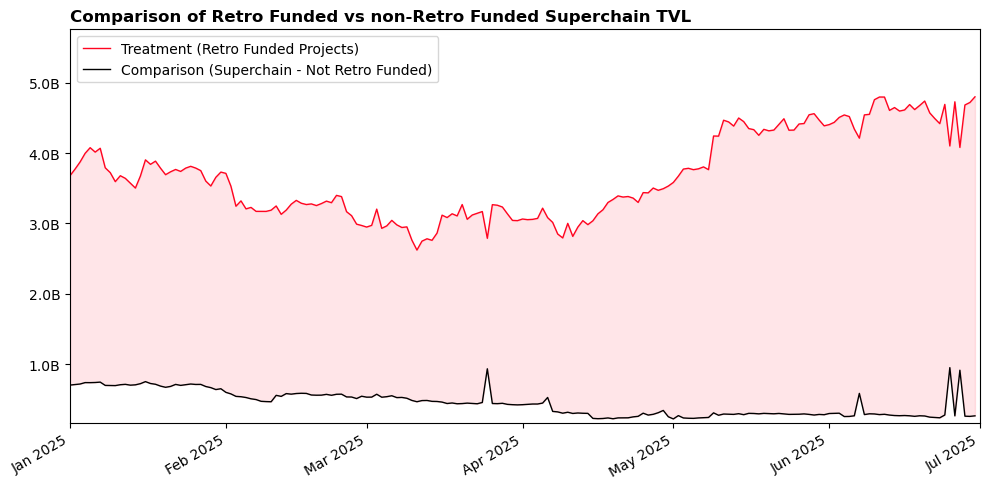

In [47]:
plot_synthetic_control(
    df_syncon_timeseries,
    dependent_metric='Defillama TVL',
    predictor_metrics=['Defillama TVL'],
    control_entity_list=['Superchain - Not Retro Funded'],
    treatment_entity='Retro Funded Projects',
    title='Comparison of Retro Funded vs non-Retro Funded Superchain TVL',
    adjusted=False
)

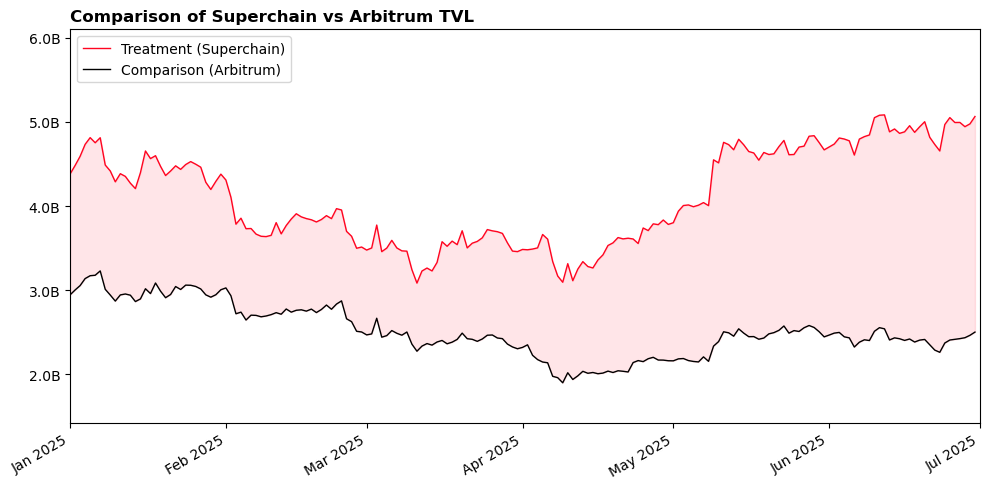

In [48]:
plot_synthetic_control(
    df_syncon_timeseries,
    dependent_metric='Defillama TVL',
    predictor_metrics=['Market Cap USD', 'Defillama TVL'],
    control_entity_list=['Arbitrum'],
    treatment_entity='Superchain',
    title='Comparison of Superchain vs Arbitrum TVL',
    adjusted=False
)

In [49]:
response = create_synth_control(
    df_timeseries=df_syncon_timeseries,
    dependent_metric='Defillama TVL',
    predictor_metrics=['Market Cap USD', 'Defillama TVL'],
    control_entity_list=['Arbitrum'],
    treatment_entity='Superchain'
)

_df = pd.DataFrame(response['data']).dropna().copy()
_df = _df[_df['date'] >= '2025-01-01']
print(_df.head(30).set_index('date').mean(axis=0).apply(int) / 1_000_000)
print(_df.tail(30).set_index('date').mean(axis=0).apply(int) / 1_000_000)
((_df.tail(30).set_index('date').mean(axis=0).apply(int) - _df.head(30).set_index('date').mean(axis=0)) / 1_000_000).apply(int)

treatment        4471.223810
synthetic        3004.167400
synthetic_adj    4468.816574
dtype: float64
treatment        4888.426449
synthetic        2423.803689
synthetic_adj    3605.502842
dtype: float64


treatment        417
synthetic       -580
synthetic_adj   -863
dtype: int64

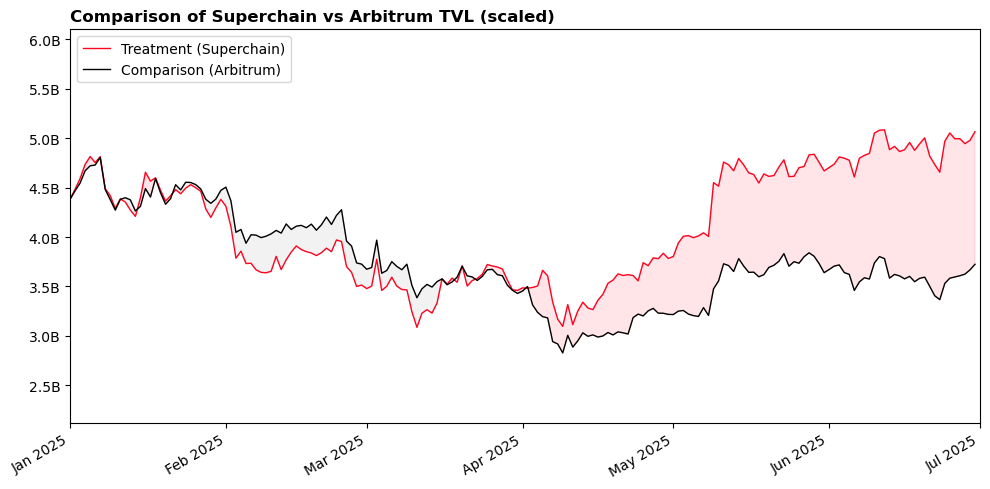

In [50]:
plot_synthetic_control(
    df_syncon_timeseries,
    dependent_metric='Defillama TVL',
    predictor_metrics=['Market Cap USD', 'Defillama TVL'],
    control_entity_list=['Arbitrum'],
    treatment_entity='Superchain',
    title='Comparison of Superchain vs Arbitrum TVL (scaled)',
    adjusted=True
)

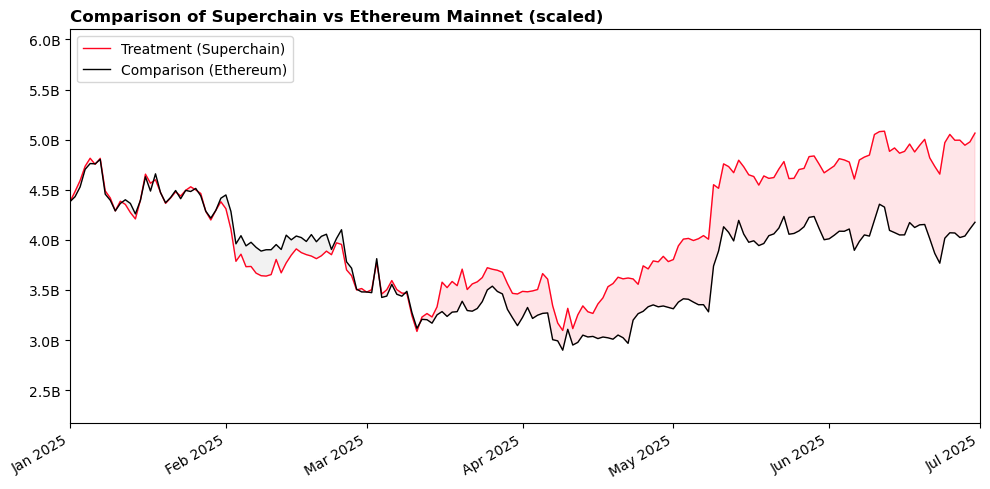

In [51]:
plot_synthetic_control(
    df_syncon_timeseries,
    dependent_metric='Defillama TVL',
    predictor_metrics=['Market Cap USD', 'Defillama TVL'],
    control_entity_list=['Ethereum'],
    treatment_entity='Superchain',
    title='Comparison of Superchain vs Ethereum Mainnet (scaled)',
    adjusted=True
)

## Observational

In [52]:
_median_reward = df_onchain_rewards[df_onchain_rewards['is_funded'] == True]['op_reward'].median()
_target_atlas_ids = list(df_onchain_rewards[df_onchain_rewards['op_reward'] >= _median_reward]['atlas_id'].unique())
_target_oso_ids = list(df_onchain_projects[df_onchain_projects['atlas_id'].isin(_target_atlas_ids)]['oso_id'].unique())

In [53]:
_target_metrics = [
    'average_tvl_monthly',
    
    'transactions_monthly',
    'internal_transactions_monthly',
    'account_abstraction_userops_monthly',
    
#    'active_upgraded_eoa_addresses_monthly',
#    'contract_invocations_upgraded_eoa_monthly',
    
#    'active_worldchain_verified_addresses_monthly',
    'worldchain_events_monthly',

#    'active_addresses_monthly',
#    'active_farcaster_users_monthly'
]

In [54]:
print(
    df_monthly_pre_post_metrics[df_monthly_pre_post_metrics['metric'].isin(_target_metrics)]
    .groupby('metric')[['pre', 'post', 'delta']]
    .sum()
    .apply(lambda x: x/1_000_000)
    .to_markdown(index=True, tablefmt='github')
)

| metric                              |         pre |        post |      delta |
|-------------------------------------|-------------|-------------|------------|
| account_abstraction_userops_monthly |    0.275014 |    0.408615 |   0.133601 |
| average_tvl_monthly                 | 3763.24     | 4563.56     | 800.325    |
| internal_transactions_monthly       |  163.79     |  227.186    |  63.3955   |
| transactions_monthly                |   45.0178   |   58.127    |  13.1092   |
| worldchain_events_monthly           |   13.1025   |   39.2101   |  26.1076   |


In [55]:
_df_daily_gas = df_gas_fees.groupby('dt')['gas_fees'].sum().reset_index()
_df_daily_gas['year'] = _df_daily_gas['dt'].apply(lambda x: x.year)
_df_daily_gas['month'] = _df_daily_gas['dt'].apply(lambda x: x.month)

def assign_period(m,y):
    if y != 2025 or m > 6:
        return None
    if m == 1:
        return 'pre'
    elif m == 6:
        return 'post'
    else:
        return 'mid'
_df_daily_gas['period'] = _df_daily_gas.apply(lambda x: assign_period(x['month'], x['year']), axis=1)

_df_daily_gas['gas_fees_rolling'] = _df_daily_gas['gas_fees'].rolling(window=30).mean()
_df_daily_gas.dropna(inplace=True)

In [56]:
_df_daily_gas_all = df_gas_fees_all.groupby('dt')['gas_fees'].sum().reset_index()
_df_daily_gas_all['year'] = _df_daily_gas_all['dt'].apply(lambda x: x.year)
_df_daily_gas_all['month'] = _df_daily_gas_all['dt'].apply(lambda x: x.month)

def assign_period(m,y):
    if y != 2025 or m > 6:
        return None
    if m == 1:
        return 'pre'
    elif m == 6:
        return 'post'
    else:
        return 'mid'
_df_daily_gas_all['period'] = _df_daily_gas_all.apply(lambda x: assign_period(x['month'], x['year']), axis=1)

_df_daily_gas_all['gas_fees_rolling'] = _df_daily_gas_all['gas_fees'].rolling(window=30).mean()
_df_daily_gas_all.dropna(inplace=True)
_df_daily_gas_all.groupby('period')['gas_fees'].sum()

period
mid     10553.293930
post     2206.036271
pre      4240.170081
Name: gas_fees, dtype: float64

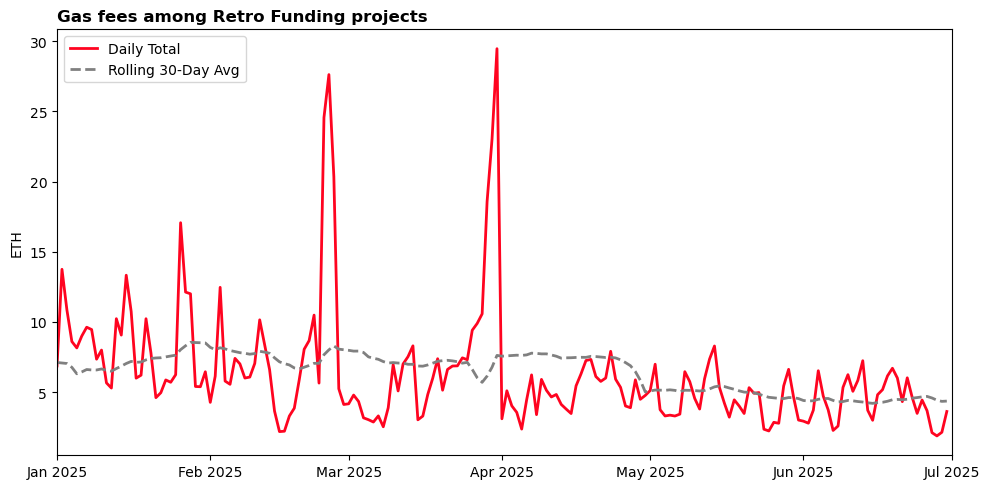

In [57]:
fig, ax = plt.subplots(figsize=(10, 5))

sns.lineplot(data=_df_daily_gas, x='dt', y='gas_fees', color='#ff0420', linewidth=2, label='Daily Total')
sns.lineplot(data=_df_daily_gas, x='dt', y='gas_fees_rolling', color='grey', linewidth=2, linestyle='--', label='Rolling 30-Day Avg')
ax.set_title('Gas fees among Retro Funding projects', weight='bold', loc='left')
ax.set_xlabel('')
ax.set_ylabel('ETH')
ax.legend(frameon=True, loc='upper left')
ax.set_xlim(pd.to_datetime('2025-01-01'), pd.to_datetime('2025-07-01'))
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
fig.autofmt_xdate(rotation=0, ha='center')

plt.tight_layout()
plt.show()

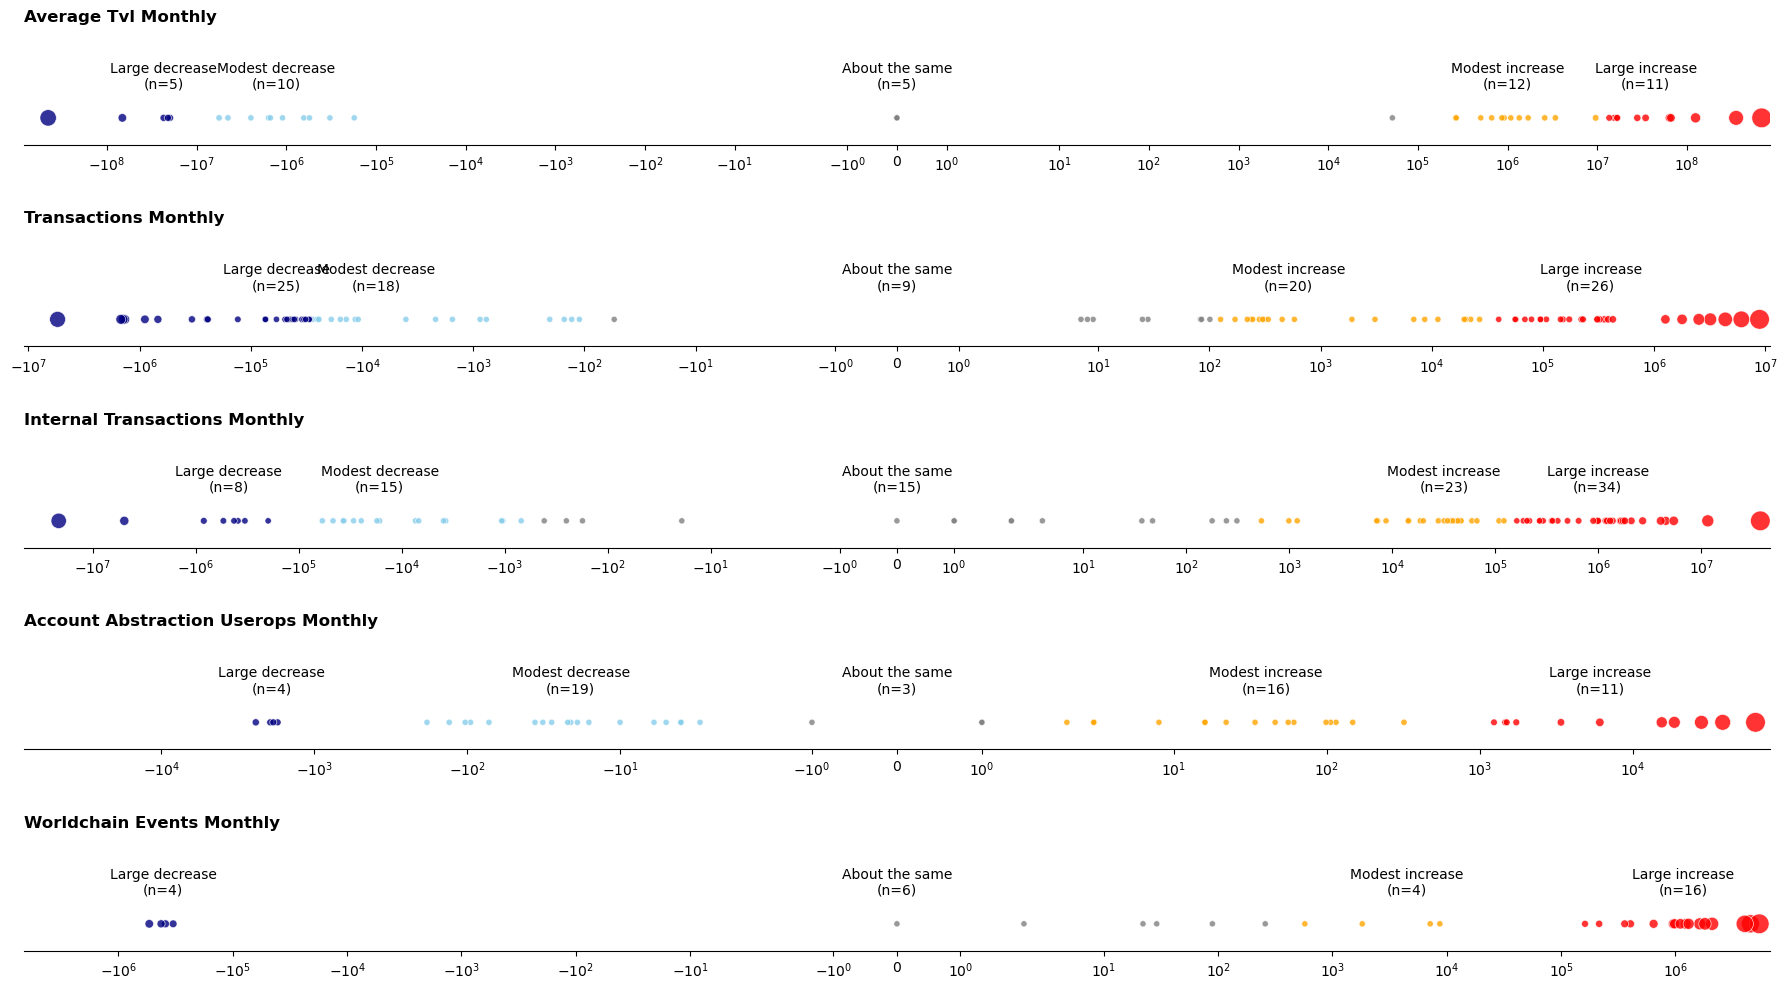

In [58]:
def impact_vector_five_categories(
    df_pre_post,
    metric,
    ax=None,
    val_col='delta',
    title=None
):
    """
    Scatter raw delta into five categories, treating 'about the same' as |delta| <= zero_thresh,
    draw threshold lines at mean, sig1, sig2, and annotate counts per category.

    Categories:
      - Large decrease: delta < -sig1
      - Modest decrease: -sig1 <= delta < -zero_thresh
      - About the same: |delta| <= zero_thresh
      - Modest increase: zero_thresh < delta <= sig1
      - Large increase: delta > sig1

    Args:
      df_pre_post (pd.DataFrame): must contain ['metric', val_col]
      metric (str)
      ax (matplotlib Axes)
      val_col (str): column for raw delta
      zero_thresh (float): threshold around zero; defaults to 5% of mean
      title (str)

    Returns:
      fig
    """
    # raw series
    series = (
        df_pre_post
        .loc[df_pre_post['metric'] == metric, val_col]
        .dropna()
        .astype(float)
    )

    # compute positive-side thresholds
    pos    = series[series > 0]
    logpos = np.log(pos)
    mu, sigma = logpos.mean(), logpos.std()
    mean = np.exp(mu)
    sig1 = np.exp(mu + 0.25 * sigma)
    sig2 = np.exp(mu + sigma)

    zero_thresh = mean * 0.01

    # define categories
    labels = [
        'Large decrease',
        'Modest decrease',
        'About the same',
        'Modest increase',
        'Large increase'
    ]
    cats = pd.Series(index=series.index, dtype='category')
    cats = cats.cat.set_categories(labels, ordered=True)
    cats.loc[series < -sig1] = 'Large decrease'
    cats.loc[(series >= -sig1) & (series < -zero_thresh)] = 'Modest decrease'
    cats.loc[(series >= -zero_thresh) & (series <= zero_thresh)] = 'About the same'
    cats.loc[(series > zero_thresh) & (series <= sig1)] = 'Modest increase'
    cats.loc[series > sig1] = 'Large increase'

    if ax is None:
        fig, ax = plt.subplots(figsize=(16, 20/8), facecolor='white')
    else:
        fig = ax.figure

    palette = {
        'Large decrease': 'navy',
        'Modest decrease': 'skyblue',
        'About the same': 'grey',
        'Modest increase': 'orange',
        'Large increase': 'red'
    }
    sns.scatterplot(
        x=series,
        y=[0] * len(series),
        hue=cats,
        palette=palette,
        size=series.abs(),
        sizes=(20, 200),
        edgecolor='w',
        linewidth=0.5,
        alpha=0.8,
        legend=False,
        ax=ax
    )

    counts = cats.value_counts().reindex(labels).fillna(0)
    for label in labels:
        count = counts[label]
        if count > 1 or label == 'About the same':
            x_med = series[cats == label].median()
            if label == 'About the same':
                x_med = 0
            ax.text(
                x_med,
                1,
                f"{label}\n(n={count})",
                ha='center',
                va='bottom',
                fontsize=10
            )
    ax.set_ylim(-1, 2)
    
    xmin = series.min()
    xmin = min(0,xmin - abs(xmin) * 0.25)
    xmax = series.max()
    xmax = xmax + abs(xmax) * 0.25
    ax.set_xscale('symlog')

    if xmax > abs(xmin):
        ax.set_xlim(-xmax, xmax)
    else:
        ax.set_xlim(xmin, abs(xmin))
    
    ax.set_yticks([])
    ax.set_xlabel('')
    ax.set_ylabel('')
    if title is None:
        title = metric.replace('_', ' ').title()
    ax.set_title(
        title + "\n\n",
        loc='left',
        fontsize=12,
        fontweight='bold'
    )
    for sp in ['top', 'right', 'left']:
        ax.spines[sp].set_visible(False)
    ax.spines['bottom'].set_visible(True)
    ax.xaxis.set_ticks_position('bottom')

W,H = 18,10
fig, axes = plt.subplots(figsize=(W,H), ncols=1, nrows=len(_target_metrics), facecolor='white')

for (i,metric_name) in enumerate(_target_metrics):
    impact_vector_five_categories(
        df_pre_post=df_monthly_pre_post_metrics[df_monthly_pre_post_metrics['project_id'].isin(_target_oso_ids)],
        metric=metric_name,
        ax=axes[i]
    ) 

fig.tight_layout()
fig.subplots_adjust(hspace=1.5)

In [59]:
_fmt = lambda x: f"{x}" if isinstance(x, str) or x < 1000 else f"{x/1000:.0f}K"

_category_summary = (
    df_project_metrics_pivoted
    .groupby('category_label')[['project_name']]
    .count()
    .rename(columns={'project_name': 'applicants'})
    .join(
        df_project_metrics_pivoted[df_project_metrics_pivoted['is_funded'] == True]
        .groupby('category_label')
        .agg(
            num_projects = ('project_name','count'),
            median_op    = ('op_reward',   'median'),        
            total_op     = ('op_reward',   'sum')     
        )
    )
    .fillna(0)
    .sort_values(by='total_op', ascending=False)
)
_category_summary['share'] = (_category_summary['total_op'] / _category_summary['total_op'].sum()).apply(lambda x: f"{x*100:.1f}%")
_category_summary = _category_summary[['applicants', 'num_projects', 'median_op', 'total_op', 'share']].applymap(_fmt).reset_index()
print(_category_summary.to_markdown(index=False, tablefmt='github'))

| category_label      |   applicants |   num_projects | median_op   | total_op   | share   |
|---------------------|--------------|----------------|-------------|------------|---------|
| Defi                |           48 |             48 | 23K         | 3400K      | 51.7%   |
| Other               |          237 |            113 | 5K          | 1367K      | 20.8%   |
| World Mini Apps     |           28 |             28 | 17K         | 983K       | 14.9%   |
| Account Abstraction |           12 |             11 | 13K         | 829K       | 12.6%   |


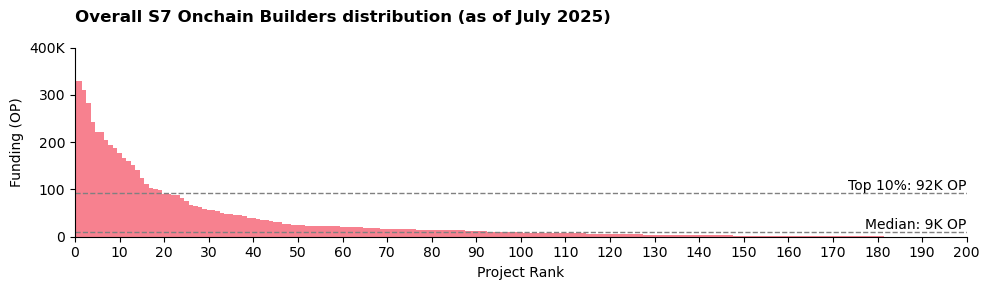

In [65]:
def format_axis(
    ax,
    xmin=None,
    xmax=None,
    xstep=None,
    ymax=None,
    ystep=None,
    xfmt=None,
    yfmt=None,
    xpost=None,
    ypost=None
):
    if xmin is not None or xmax is not None:
        ax.set_xlim(xmin, xmax)
    
    if xstep is not None:
        xticks = np.arange(xmin if xmin is not None else 0, xmax + xstep, xstep)
        ax.set_xticks(xticks)        
        if isinstance(xfmt, str):
            xtick_labels = [format(tick, xfmt) for tick in xticks]
        elif callable(xfmt):
            xtick_labels = [xfmt(tick) for tick in xticks]
        else:
            xtick_labels = [str(tick) for tick in xticks]

        if xpost:
            xtick_labels[-1] += f"{xpost}"
        ax.set_xticklabels(xtick_labels)
    if xpost is not None and not ax.get_xlabel():
        ax.set_xlabel(xpost)

    if ymax is not None:
        ax.set_ylim(0, ymax)
    if ystep is not None:
        yticks = np.arange(0, ymax + ystep, ystep)
        ax.set_yticks(yticks)        
        if isinstance(yfmt, str):
            ytick_labels = [format(tick, yfmt) for tick in yticks]
        elif callable(yfmt):
            ytick_labels = [yfmt(tick) for tick in yticks]
        else:
            ytick_labels = [str(tick) for tick in yticks]
        if ypost:
            ytick_labels[-1] += f"{ypost}"
        ax.set_yticklabels(ytick_labels)
    if ypost is not None and not ax.get_ylabel():
        ax.set_ylabel(ypost)

    return ax

fig, ax = plt.subplots(figsize=(10, 3))
series = df_project_metrics_pivoted[df_project_metrics_pivoted['is_funded']]['op_reward']
series = series.sort_values(ascending=False) / 1000
series.plot(kind='bar', color='#F00420', alpha=.5, ax=ax, width=1)
xmax = len(series)

format_axis(
    ax,
    xmin=0, 
    xmax=200, 
    xstep=10, 
    ymax=400, 
    ystep=100,
    ypost="K",
    yfmt=".0f"
)

ax.set_xlabel("Project Rank")
ax.tick_params(axis='x', rotation=0)
ax.set_ylabel("Funding (OP)")

med = series.median()
ax.axhline(med, color='grey', linestyle='--', lw=1)
ax.text(s=f"Median: {med:.0f}K OP", x=xmax, y=med, va='bottom', ha='right')    

top10 = series.quantile(.9)
ax.axhline(top10, color='grey', linestyle='--', lw=1)
ax.text(s=f"Top 10%: {top10:.0f}K OP", x=xmax, y=top10, va='bottom', ha='right')    

title = 'Overall S7 Onchain Builders distribution (as of July 2025)'
ax.set_title(f"{title}\n", loc='left', weight='bold')
sns.despine()
fig.tight_layout()